In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy import integrate

In [2]:
class SocialSpatialModel:
    def __init__(self, grid_size, subpopulations, n_infected, contact_rates, exposure_rate, recovery_rate, epsilon, baseline_activity_rate, income_values):
            self.m = grid_size
            self.N_k = np.array(subpopulations)
            self.I_0 = np.array(n_infected)
            self.A = np.array(contact_rates)  # This will be adjusted based on activity rates
            self.alpha = exposure_rate
            self.gamma = recovery_rate
            self.epsilon = epsilon
            self.baseline_activity_rate = baseline_activity_rate
            self.income_values = income_values
            self.Q = self.compute_vulnerability(income_values)  # update use logistic model
            self.A = self.compute_activity_rate()  # 3.7: update activity rate using the compute activity rate method. 
            self.B = self.compute_beta()
            


    def compute_beta(self):
        m2 = self.m**2
        B = np.zeros((m2, m2)) # initialize beta with zeros

        denominator = np.sum(self.A * self.N_k) # denominator of the beta formula
        indices_2d = [(i // self.m, i % self.m) for i in range(m2)] # change to 2d grid index, for checking neighbor

        # case 1: i and j are neighbors (up, down, left, right)
        for i in range(m2):
            for j in range(m2):
                if i != j:
                    diff = (abs(indices_2d[i][0] - indices_2d[j][0]), abs(indices_2d[i][1] - indices_2d[j][1]))
                    if diff in [(1, 0), (0, 1)]:  # check for up, down, left, right
                        B[i, j] = (1 - self.epsilon) * self.Q[i] * self.A[i] * self.A[j] / denominator
        # case 2: i = j, self transmission rate
        for i in range(m2):
            B[i, i] = (1 - self.epsilon) * self.Q[i] * self.A[i]**2 / denominator + self.epsilon * self.Q[i] * self.A[i] / self.N_k[i]

        return B
    
    def compute_vulnerability(self, income_levels):
        # vulnerability based on income levels
        logit_q = np.zeros_like(income_levels, dtype=float)
        for i, income in enumerate(income_levels):
            Z1 = 1 if 0.25 < income <= 0.50 else 0  # T1
            Z2 = 1 if income > 0.50 else 0  # T2
            logit_q[i] = -2 + Z1 + 2 * Z2
        
        # turn logit to probability
        q = 1 / (1 + np.exp(-logit_q))
        return q
    
    def compute_activity_rate(self):
        mul = np.random.uniform(2, 3, size = self.N_k.shape)
        baseline_activity_rate = 12
        adjusted_activity_rate = baseline_activity_rate * mul * income_values.flatten()
        return adjusted_activity_rate
    
    def get_initial_state(self):
        # need to return X where X = (S, E, I, R)
        S0 = self.N_k - self.I_0
        E0 = np.zeros_like(self.N_k)
        I0 = self.I_0
        R0 = np.zeros_like(self.N_k)
        return np.concatenate([S0, E0, I0, R0])  # N^2 * 4 # a vector

    def derivative(self, X, t):
      m2 = self.m**2
      S, E, I, R = X[:m2], X[m2:2*m2], X[2*m2:3*m2], X[3*m2:]

      dsdt = -self.B @ I * S
      dedt = self.B @ I * S - self.alpha * E
      didt = self.alpha * E - self.gamma * I
      drdt = self.gamma * I

      S_new = S + dsdt
      threshold = 0 
      S_new = np.clip(S_new, threshold, self.N_k)  

      return np.concatenate([S_new - S, dedt, didt, drdt])

In [3]:
# example of 3 by 3 grid
grid_size = 3
pop_grid = np.array([[1000, 1000, 1000], 
                     [1000, 10000, 10000], 
                     [1000, 10000, 100000]])
income_values = np.array([[0.3, 0.3, 0.3],
                          [0.3, 0.1, 0.1],
                          [0.3, 0.1, 0.6]])
initial_infected = (2, 2)  # central cell

pop = pop_grid.flatten() # make population array into 1d
income = income_values.flatten()

n_infected = np.zeros_like(pop)
n_infected[grid_size * initial_infected[0] + initial_infected[1]] = 1

contact_rates = np.full(pop.shape, 1.0) # assume now the contact rates are same across the grid, = 1

epsilon = 0.8
exposure_rate = 0.2  # rate of exposed becoming infectious
recovery_rate = 0.1  # recovery rate of infectious

subpop = pop - n_infected # not sure CHECKPOINT

model = SocialSpatialModel(grid_size = grid_size, 
                           subpopulations = subpop, 
                           n_infected = n_infected, 
                           contact_rates = contact_rates, 
                           exposure_rate = exposure_rate, 
                           recovery_rate = recovery_rate, 
                           epsilon = epsilon,
                           baseline_activity_rate=12,
                           income_values=income)

initial_state = model.get_initial_state()
beta_matrix = model.compute_beta()

C:\Users\enzog\AppData\Local\Temp\ipykernel_31228\4256186745.py:68: RuntimeWarning: overflow encountered in multiply
  dsdt = -self.B @ I * S
C:\Users\enzog\AppData\Local\Temp\ipykernel_31228\4256186745.py:69: RuntimeWarning: overflow encountered in multiply
  dedt = self.B @ I * S - self.alpha * E
C:\Users\enzog\AppData\Local\Temp\ipykernel_31228\521888251.py:10: RuntimeWarning: invalid value encountered in add
  X += dXdt * dt # update the state directly
C:\Users\enzog\AppData\Local\Temp\ipykernel_31228\4256186745.py:68: RuntimeWarning: invalid value encountered in matmul
  dsdt = -self.B @ I * S
C:\Users\enzog\AppData\Local\Temp\ipykernel_31228\4256186745.py:69: RuntimeWarning: invalid value encountered in matmul
  dedt = self.B @ I * S - self.alpha * E


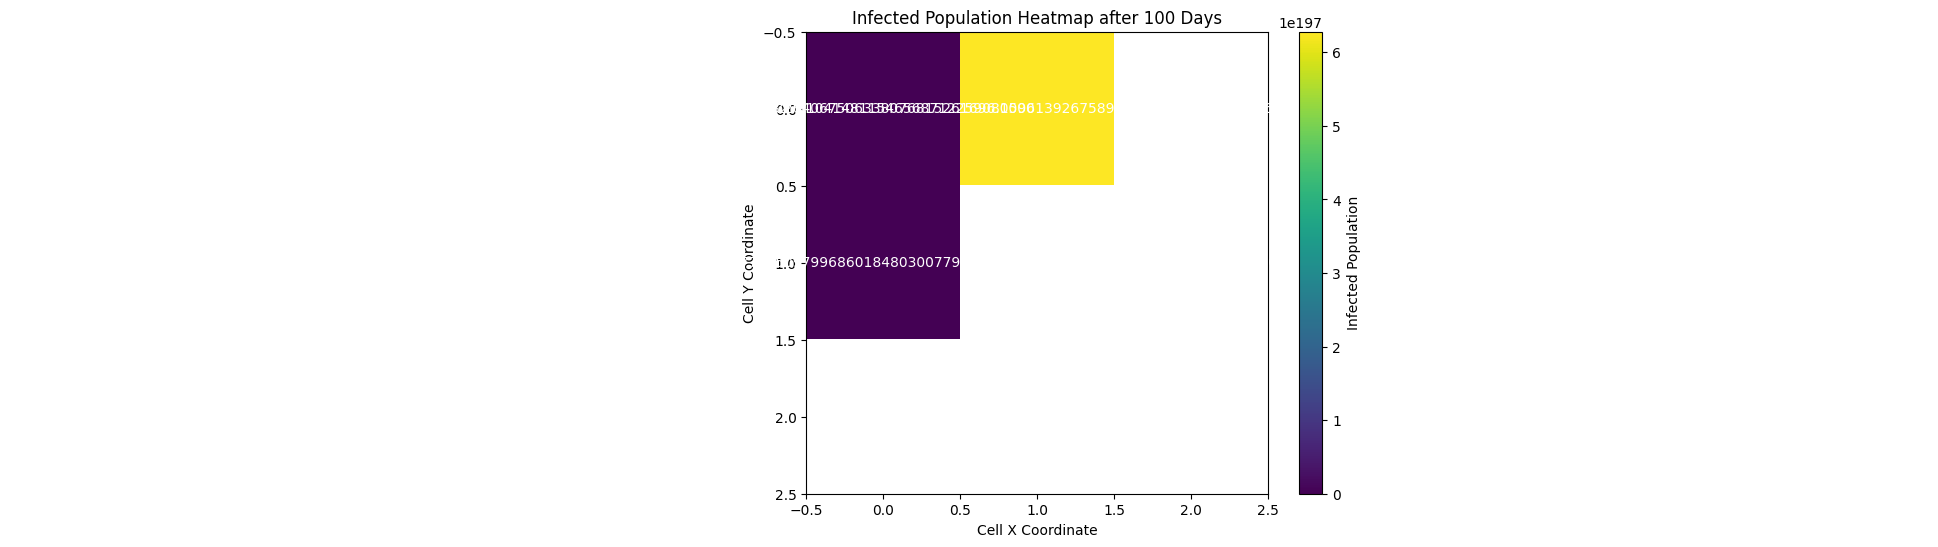

In [4]:
days = 50  # number of days
dt = 1.0   # time step

t = np.arange(0, days, dt)
X = model.get_initial_state().astype(np.float64)
num = model.m ** 2

total_susceptible = []
total_exposed = []
total_infected = []
total_recovered = []



for _ in t:
    dXdt = model.derivative(X, _) # calculate the derivatives
    X += dXdt * dt # update the state directly
    S, E, I, R = X[:num], X[num:2*num], X[2*num:3*num], X[3*num:]

    S_total = np.sum(X[:num])
    E_total = np.sum(X[num:2*num])
    I_total = np.sum(X[2*num:3*num])
    R_total = np.sum(X[3*num:])
    
    total_infected.append(I_total)
    total_exposed.append(E_total)
    total_susceptible.append(S_total)
    total_recovered.append(R_total)

In [ ]:
# Plot for total infected
plt.figure(figsize=(10, 6))
plt.plot(t, total_infected, label='Total Infected')
plt.xlabel('Time (days)')
plt.ylabel('Total Infected Population')
plt.title('Total Infected Population Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# here is to reshape to extract the infected population for the heatmap
S, E, I, R = X[:num], X[num:2*num], X[2*num:3*num], X[3*num:]
infected_pop = R.reshape(model.m, model.m)

fig, ax = plt.subplots(figsize = (8, 6))
cax = ax.imshow(infected_pop, cmap = 'viridis', interpolation = 'nearest')

for i in range(infected_pop.shape[0]):
    for j in range(infected_pop.shape[1]):
        text = ax.text(j, i, f'{infected_pop[i, j]:.4f}', ha = "center", va = "center", color = "w")

plt.colorbar(cax, label='Infected Population')
plt.title('Infected Population Heatmap after 100 Days')
plt.xlabel('Cell X Coordinate')
plt.ylabel('Cell Y Coordinate')
plt.show()